In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # removes the warning messages from tensorflow

In [2]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
import pywt
import funcs
import plot_learning_callback
import f1_metric

In [3]:
# use gpu

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')

oneHotTrain = funcs.one_hot_encoder(trainDiagnostic, 2)
oneHotValidate = funcs.one_hot_encoder(validateDiagnostic, 2)
oneHotTest = funcs.one_hot_encoder(testDiagnostic, 2)

In [5]:
# data is imbalanced so we balance it

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainDiagnostic),
                                        y = trainDiagnostic                                                    
                                    )
class_weights = dict(zip(np.unique(trainDiagnostic), class_weights))

sigmoidLoss = tf.keras.losses.BinaryCrossentropy() # one output unit
softmaxLoss = tf.keras.losses.CategoricalCrossentropy() # two output units

In [6]:
scales = np.linspace(0.1, 4, 20) # scales to use for cwt

trainTransform = funcs.make_for_cnn(trainReadings, scales, 'mexh') # apply CWT to all training data
validateTransform = funcs.make_for_cnn(validateReadings, scales, 'mexh')
testTransform = funcs.make_for_cnn(testReadings, scales, 'mexh')

trainTransform.shape

(10977, 1000, 20)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, metrics, callbacks

In [8]:
inputShape = trainTransform.shape[1:]
kernelSize = 40 #how to determine this

In [9]:
#adding these layers keeps the weights the same???????

convInputLayer = layers.Conv1D(
    filters=64, 
    kernel_size=kernelSize, 
    input_shape=trainTransform.shape[1:], 
    data_format="channels_last", 
    padding='same')

convLayer = layers.Conv1D(
    filters=64, 
    kernel_size=kernelSize, 
    padding='same')

batchNormLayer = layers.BatchNormalization(axis=-1)

reLULayer = layers.ReLU()

maxPoolLayer = layers.MaxPooling1D(
    pool_size=kernelSize * 2, 
    strides=None, 
    padding='same') # should the size of the pooling layer be the same as the kernel size

In [10]:
metrics=['accuracy', 
         tf.keras.metrics.Precision(name='precision'), 
         tf.keras.metrics.Recall(name='recall'),
         f1_metric.f1]

# Test out alternative architectures

In [11]:
# adding dropout layer to prevent overfitting

tf.random.set_seed(42)

inputDroppedPercent = 20 # during training, 20 percent of the inputs (to the dropout layer) are randomly dropped
dropoutLayer = layers.Dropout(inputDroppedPercent / 100)
sectionRepeat = 3

In [12]:
model = Sequential()

model.add(layers.Conv1D(
    filters=64, 
    kernel_size=kernelSize, 
    input_shape=inputShape, 
    data_format="channels_last", 
    padding='same'))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Dropout(inputDroppedPercent / 100))
model.add(layers.ReLU())
model.add(layers.MaxPooling1D(
    pool_size=kernelSize * 2, 
    strides=None, 
    padding='same'))

for i in range(sectionRepeat):
    model.add(layers.Conv1D(
        filters=64, 
        kernel_size=kernelSize, 
        padding='same'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.Dropout(inputDroppedPercent / 100))
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(
        pool_size=kernelSize * 2, 
        strides=None, 
        padding='same'))
    

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [13]:
# create a checkpoint for the best val

currentDirectory = os.getcwd()
f1FileName = 'best_f1.hdf5' # model weights are stored in hdf5 file
accuracyFileName = 'best_accuracy.hdf5'

f1File = os.path.join(currentDirectory, 'ckpt', f1FileName)
accuracyFile = os.path.join(currentDirectory, 'ckpt', accuracyFileName)

f1Checkpoint = callbacks.ModelCheckpoint(filepath=f1File, 
                                       save_weights_only=True, 
                                       monitor='val_f1',
                                       mode='max', #save when the f1 score is the highest
                                       save_best_only=True, 
                                      )
accuracyCheckpoint = callbacks.ModelCheckpoint(filepath=f1File, 
                                       save_weights_only=True, 
                                       monitor='val_accuracy',
                                       mode='max', #save when the accuracy is the highest
                                       save_best_only=True, 
                                      )

In [14]:
model.compile(
    optimizer='adam', loss=sigmoidLoss, 
 metrics=metrics)

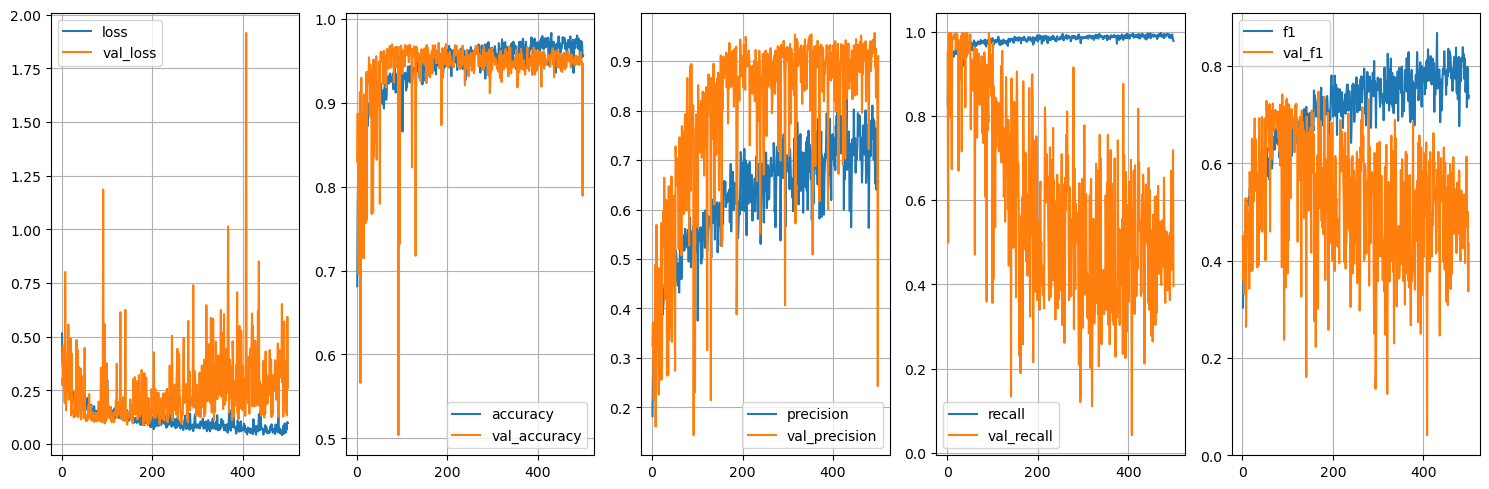

344/344 [==============================] - 21s 60ms/step - loss: 0.0969 - accuracy: 0.9564 - precision: 0.6575 - recall: 0.9778 - f1: 0.7390 - val_loss: 0.2589 - val_accuracy: 0.9462 - val_precision: 0.9098 - val_recall: 0.3954 - val_f1: 0.4352


In [15]:
history = model.fit(
    trainTransform, trainDiagnostic, 
    epochs=500,
    validation_data=(validateTransform, validateDiagnostic), 
    class_weight=class_weights,
    callbacks=[plot_learning_callback.PlotLearning(), f1Checkpoint],
    batch_size=32
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1000, 64)          51264     
                                                                 
 batch_normalization_1 (Batc  (None, 1000, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1000, 64)          0         
                                                                 
 re_lu_1 (ReLU)              (None, 1000, 64)          0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 64)            1

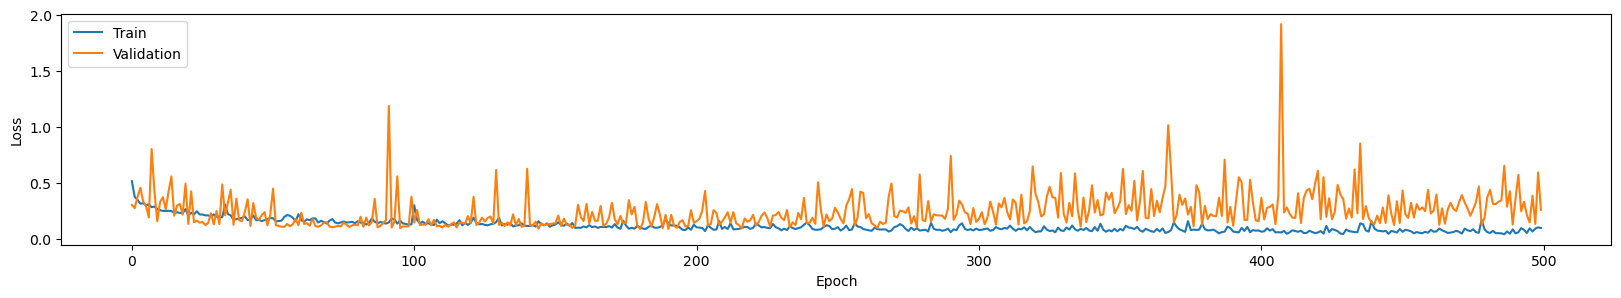

In [28]:
funcs.graph_losses(history, "Loss")

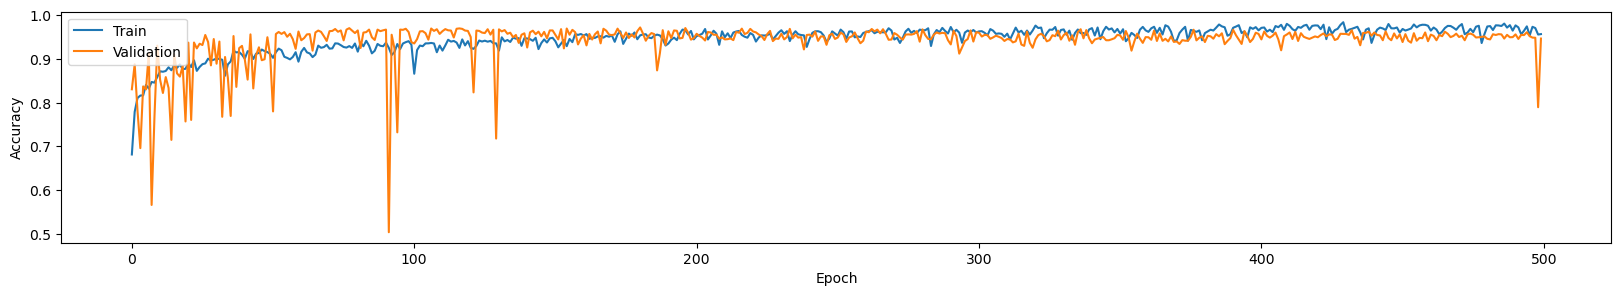

In [29]:
funcs.graph_losses(history, "Accuracy")

[]

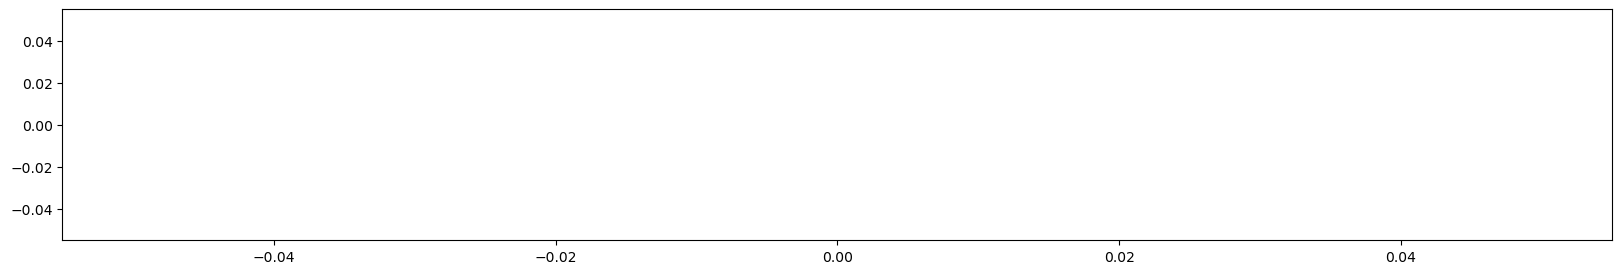

In [30]:
plt.figure(figsize=(20, 3))
plt.plot()

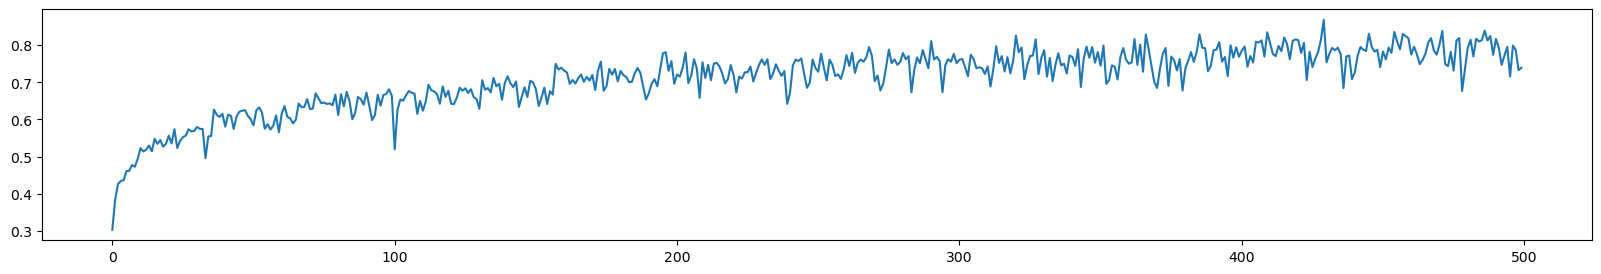

In [31]:
plt.figure(figsize=(20, 3))
plt.plot(history.history['f1'])

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'])

In [40]:
model.evaluate(validateTransform, validateDiagnostic)

115/115 [==============================] - 1s 11ms/step - loss: 0.2589 - accuracy: 0.9462 - precision: 0.9098 - recall: 0.3954 - f1: 0.4352


[0.25890982151031494,
 0.9461601376533508,
 0.9097744226455688,
 0.39542484283447266,
 0.43522587418556213]

In [34]:
bestf1Model = tf.keras.models.clone_model(model)

In [35]:
bestf1Model.compile(
    optimizer='adam', loss=sigmoidLoss, 
 metrics=metrics)

In [36]:
bestf1Model.load_weights('ckpt/bestf1.hdf5')

In [37]:
bestf1Model.evaluate(validateTransform, validateDiagnostic)

115/115 [==============================] - 2s 11ms/step - loss: 0.4539 - accuracy: 0.7953 - precision: 0.3536 - recall: 0.6933 - f1: 0.4166


[0.4538998305797577,
 0.7952992916107178,
 0.3535773754119873,
 0.6933115720748901,
 0.4166340231895447]

In [43]:
max(history.history['val_recall'])

0.9967319965362549

In [41]:
max(history.history['val_accuracy'])

0.9715769290924072